In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
from pywrdrb.pywr_drb_node_data import immediate_downstream_nodes_dict
start_date = '1983-06-01'
end_date = '2017-05-31'
cms_to_mgd = 22.82

In [25]:
pub_df = pd.read_csv(f'../input_data/catchment_inflow_obs_pub.csv', sep=',', index_col=0, parse_dates=True).loc[start_date:end_date,:]
nhm_df = pd.read_csv(f'../input_data/catchment_inflow_nhmv10.csv', sep=',', index_col=0, parse_dates=True).loc[start_date:end_date,:]
nwm_df = pd.read_csv(f'../input_data/catchment_inflow_nwmv21.csv', sep = ',', index_col=0, parse_dates=True).loc[start_date:end_date,:]
obs_df = pd.read_csv(f'../input_data/catchment_inflow_obs.csv', sep = ',', index_col=0, parse_dates=True).loc[start_date:end_date,:]
pub_flow_df = pd.read_csv(f'../input_data/gage_flow_obs_pub.csv', sep=',', index_col=0, parse_dates=True).loc[start_date:end_date,:]


quantiles =[0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]

pub_fdc = np.zeros([pub_df.shape[1], len(quantiles)])
nhm_fdc = np.zeros([nhm_df.shape[1], len(quantiles)])
nwm_fdc = np.zeros([nwm_df.shape[1], len(quantiles)])
for i, node in enumerate(nhm_df.columns):
    pub_fdc[i,:] = np.quantile(pub_df.loc[:,node].to_numpy(), quantiles)
    nhm_fdc[i,:] = np.quantile(nhm_df.loc[:,node].to_numpy(), quantiles) 
    nwm_fdc[i,:] = np.quantile(nwm_df.loc[:,node].to_numpy(), quantiles)   
nhm_fdc_df = pd.DataFrame(nhm_fdc, index = nhm_df.columns, columns=quantiles)
pub_fdc_df = pd.DataFrame(pub_fdc, index = nhm_df.columns, columns=quantiles)
nwm_fdc_df = pd.DataFrame(nwm_fdc, index = nhm_df.columns, columns=quantiles)
#nhm_fdc_df.to_csv('./input_data/modeled_gages/nhmv10_node_fdc.csv', sep = ',')

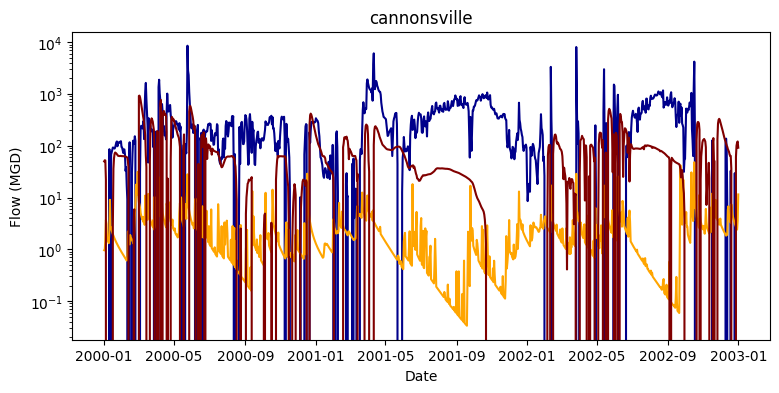

In [24]:
node = 'cannonsville'

fig, ax = plt.subplots(figsize=(9,4))
ts = pd.date_range('2000-01-01', '2003-01-01').date
# ax.plot(ts, pub_df.loc[ts, node], label = 'Obs-PUB Inflow', color = 'lightblue')
# ax.plot(ts, nhm_df.loc[ts, node], label = 'NHMv1.0 Inflow', color = 'gold')
# ax.plot(ts, nwm_df.loc[ts, node], label = 'NWMv2.1 Inflow', color = 'maroon')

ax.plot(ts, pub_df.loc[ts, immediate_downstream_nodes_dict[node]], label = 'Obs-PUB Outflow', color = 'darkblue')
ax.plot(ts, nhm_df.loc[ts, immediate_downstream_nodes_dict[node]], label = 'NHMv1.0 Outflow', color = 'orange')
ax.plot(ts, nwm_df.loc[ts, immediate_downstream_nodes_dict[node]], label = 'NWMv2.1 Outflow', color = 'maroon')
plt.title(node)
plt.ylabel('Flow (MGD)')
plt.xlabel('Date')
plt.yscale('log')
plt.show()

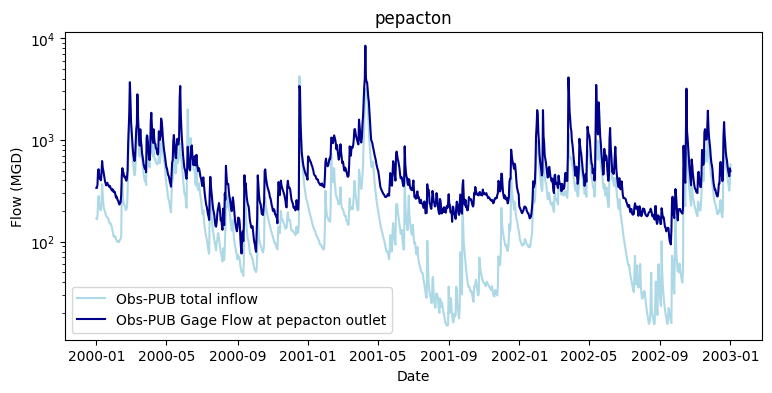

In [31]:
node = 'pepacton'

fig, ax = plt.subplots(figsize=(9,4))
ts = pd.date_range('2000-01-01', '2003-01-01').date
ax.plot(ts, pub_flow_df.loc[ts, node], label = f'Obs-PUB total inflow', color = 'lightblue')
ax.plot(ts, pub_flow_df.loc[ts, immediate_downstream_nodes_dict[node]], label = f'Obs-PUB Gage Flow at {node} outlet', color = 'darkblue')
plt.title(node)
plt.ylabel('Flow (MGD)')
plt.xlabel('Date')
plt.legend()
plt.yscale('log')
plt.show()

In [3]:

pub_reservoirs = ['cannonsville',
                    'pepacton',
                    'neversink',
                    'wallenpaupack', ## Note, wanted to do 01431500 minus 01432110, but don't have latter from Aubrey, so use Prompton for now
                    'prompton',
                    'shoholaMarsh', ## Note, Shohola has no inlet gauge
                    'mongaupeCombined', # NOTE, this is an outlet.  TODO See:  01432900
                    'beltzvilleCombined',  ## NOTE, This is the outlet. TODO See: 01449360
                    'fewalter',
                    'merrillCreek', ## Merrill Creek doesnt have gage - use Nockamixon nearby to get flow shape
                    'hopatcong',  ## NOTE, this is an outlet. There are inlet gauges with poor records
                    'nockamixon', ## NOTE, this is far downstream of outlet.
                    'assunpink', 
                    'ontelaunee',
                    'stillCreek', 
                    'blueMarsh',
                    'greenLane',
                    'marshCreek']

pub_df = pub_df.loc[:,pub_reservoirs]
nhm_df = nhm_df.loc[:,pub_reservoirs]
nwm_df = nwm_df.loc[:,pub_reservoirs]

pub_df= pub_df.assign(Dataset='PUB')
nhm_df=nhm_df.assign(Dataset='NHMv10')
nwm_df=nwm_df.assign(Dataset='NWMv21')

cdf = pd.concat([pub_df, nhm_df, nwm_df])    
mdf = pd.melt(cdf, id_vars=['Dataset'], var_name=['Node'])
mdf.value.name = "Inflow (MGD)"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


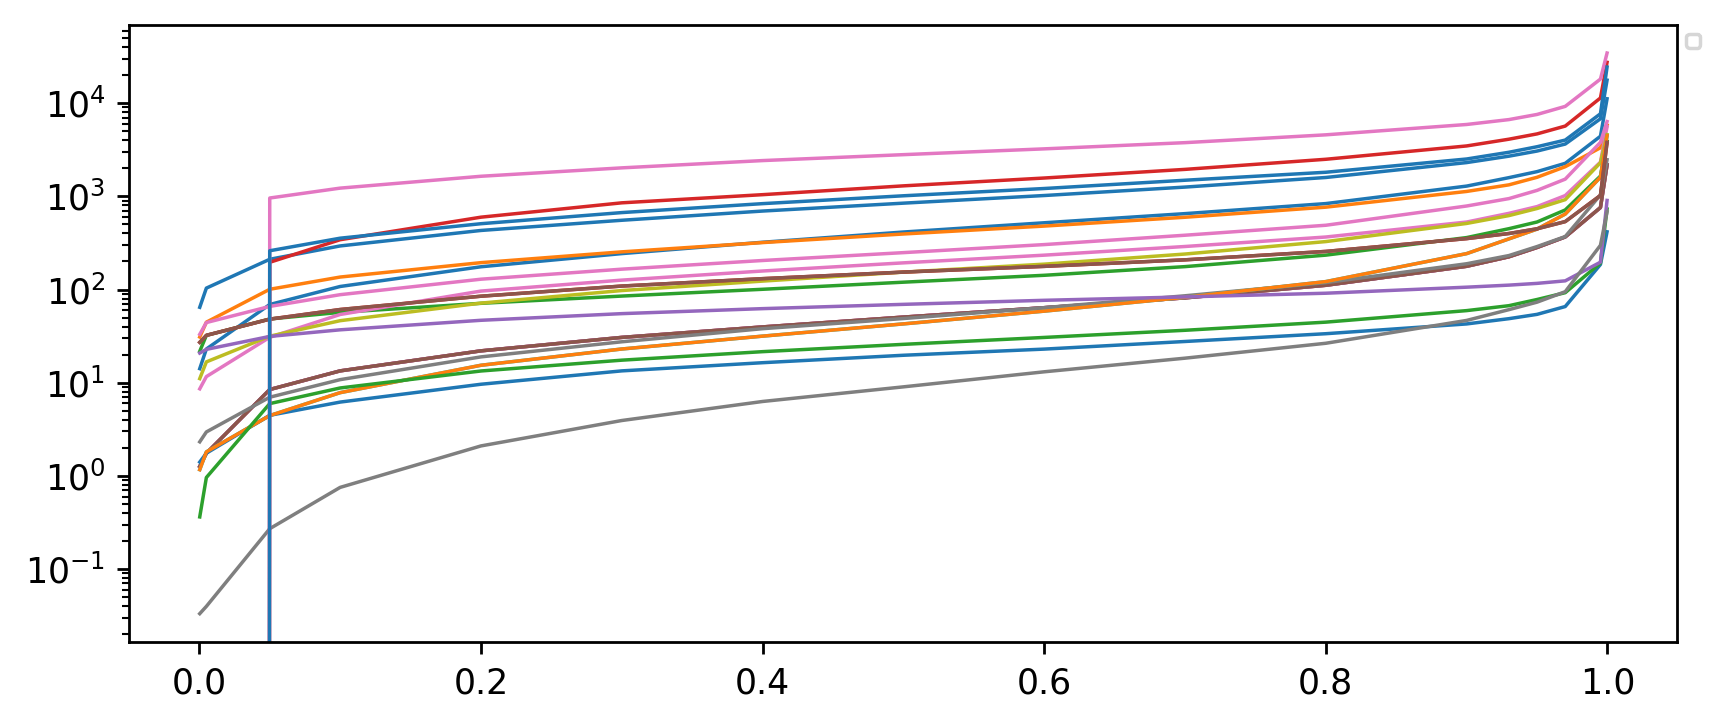

In [4]:

fig, ax = plt.subplots(figsize = (7,3), dpi =250)
for i in range(nhm_fdc.shape[0]):
    ax.plot(quantiles, nhm_fdc[i,:], alpha= 1, linewidth = 1)
plt.yscale('log')
plt.yscale('log')
plt.legend(fontsize = 5, bbox_to_anchor = (1.0,1.0), loc = 'upper left', ncol = 2)
plt.tight_layout()
plt.show()

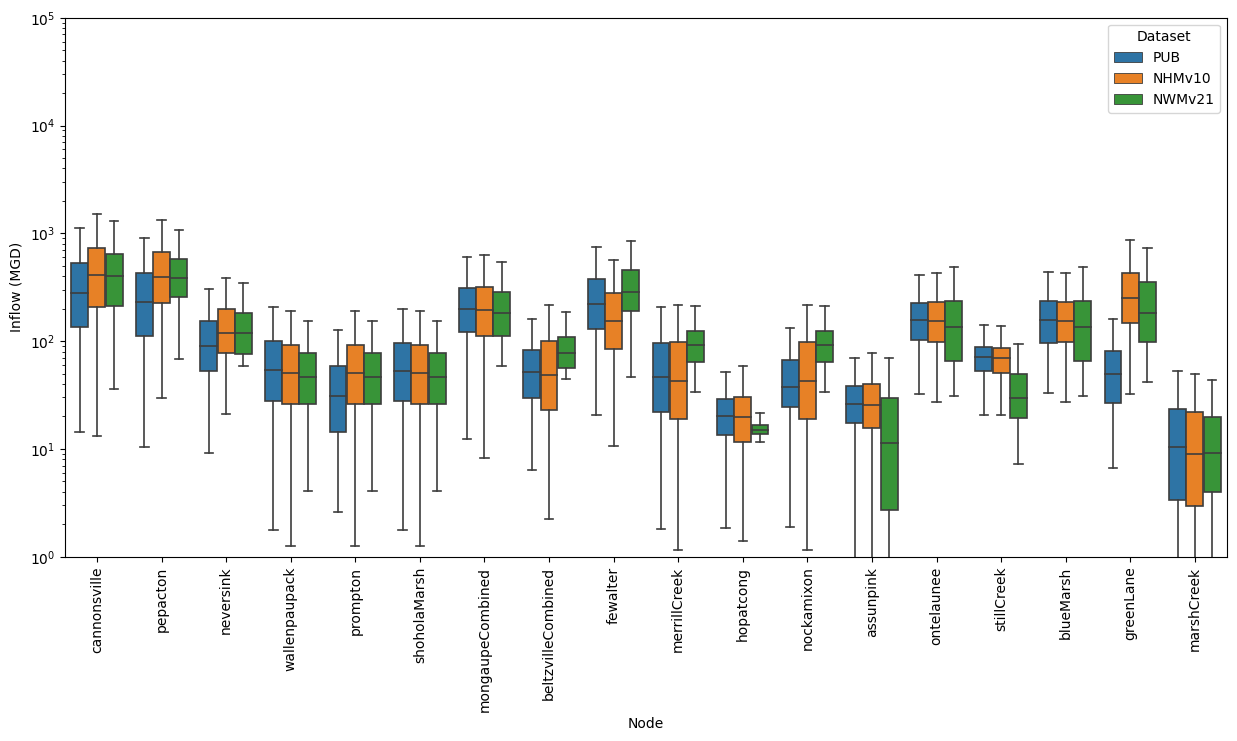

In [5]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(x="Node", y="value", hue="Dataset", data=mdf, 
                 showfliers=False, linewidth=1.2, saturation=0.8)
ax.set(ylim=(1, 100000))
ax.tick_params(axis='x', rotation=90)    
for patch in ax.artists:
    r,g,b,a = patch.get_facecolor()
    patch.set_edgecolor((0,0,0,.0))
    patch.set_facecolor((r,g,b,.0))
plt.yscale('log')
plt.savefig(f'figs/inflow_comparison.png')
plt.show()